<a href="https://colab.research.google.com/github/ZobayerAbedin/DeepLearning/blob/main/digitRecognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import time
from torchsummary import summary

device = torch.device('cpu')

if torch.cuda.is_available():
  device = torch.device('cuda')

In [3]:
print(device)

cuda


# Data Manipulation


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Data/digit-recognizer/train.csv')
data = df.to_numpy()
labels = data[:, 0]
data = data[:, 1:]

In [6]:
df.shape

(42000, 785)

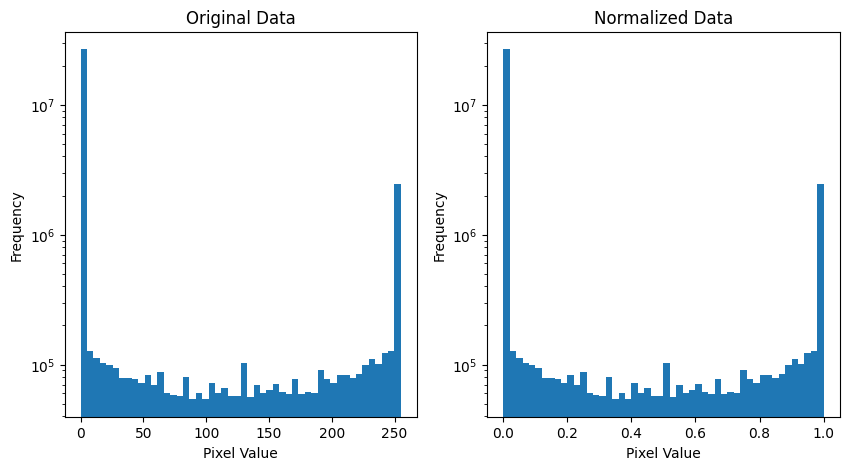

In [7]:
dataNorm = data / np.max(data)

fig, aa = plt.subplots(1, 2, figsize=(10, 5))
aa[0].hist(data.flatten(), 50)
aa[0].set_yscale('log')
aa[0].set_title('Original Data')
aa[0].set_xlabel('Pixel Value')
aa[0].set_ylabel('Frequency')

aa[1].hist(dataNorm.flatten(), 50)
aa[1].set_yscale('log')
aa[1].set_title('Normalized Data')
aa[1].set_xlabel('Pixel Value')
aa[1].set_ylabel('Frequency')

plt.show()


In [8]:
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

trainDataT, testDataT, trainLabelsT, testLabelsT = train_test_split(dataT, labelsT, test_size = 0.1)

trainData = TensorDataset(trainDataT, trainLabelsT)
testData = TensorDataset(testDataT, testLabelsT)

batchSize = 16

trainLoader = DataLoader(trainData, batch_size = batchSize, shuffle = True, drop_last = True)
testLoader = DataLoader(testData, batch_size = testData.tensors[0].shape[0])

# Model


In [9]:
def createNet():
  class xNet(nn.Module):
    def __init__(self):
      super().__init__()

      #input layer
      self.input = nn.Linear(784, 512)

      #hidden layer
      self.l1 = nn.Linear(512, 256)
      self.l2 = nn.Linear(256, 128)
      self.l3 = nn.Linear(128, 64)
      self.l4 = nn.Linear(64, 32)

      #output layer
      self.output = nn.Linear(32, 10)


    def forward(self, x):
      x = F.relu(self.input(x))
      x = F.relu(self.l1(x))
      x = F.relu(self.l2(x))
      x = F.relu(self.l3(x))
      x = F.relu(self.l4(x))

      return torch.log_softmax(self.output(x), dim = 1)

  net = xNet()
  lossFun = nn.NLLLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)

  return net, lossFun, optimizer

In [10]:
net, lossFun, optimizer = createNet()
if device != 'cpu':
  net = net.to(device)
summary(net, input_size = (1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]         401,920
            Linear-2               [-1, 1, 256]         131,328
            Linear-3               [-1, 1, 128]          32,896
            Linear-4                [-1, 1, 64]           8,256
            Linear-5                [-1, 1, 32]           2,080
            Linear-6                [-1, 1, 10]             330
Total params: 576,810
Trainable params: 576,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.20
Estimated Total Size (MB): 2.21
----------------------------------------------------------------


# Test

In [11]:
def testNet(net, lossFun, optimizer, testLoader):
  data = testLoader.dataset.tensors[0]
  labels = testLoader.dataset.tensors[1]

  if device != 'cpu':
    data = data.to(device)
    labels = labels.to(device)

  with torch.no_grad():
    pred = net(data)

  if device != 'cpu':
    labels = labels.cpu()
    pred = pred.cpu()

  matches = (torch.argmax(pred, axis = 1) == labels).float()
  acc = 100 * torch.mean(matches)

  return acc

# Train

In [12]:
def trainNet(net, lossFun, optimizer):
  epoch = 50

  timeStart = time.process_time()
  timeNow = timeStart

  trainAcc = []
  trainLoss = []
  testAcc = []

  for _ in range(epoch):

    batchAcc = []
    batchLoss = []

    for data, labels in trainLoader:
      data = data.to(device)
      labels = labels.to(device)


      ## calculate forward pass and loss
      pred = net(data)
      loss = lossFun(pred, labels)

      ## backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      ## accurecy and loss
      pred = pred.cpu()
      labels = labels.cpu()
      matches = (torch.argmax(pred, axis = 1) == labels).float()
      acc = 100 * torch.mean(matches)


      batchAcc.append(acc)
      batchLoss.append(loss.item())

    trainAcc.append(np.mean(batchAcc))
    trainLoss.append(np.mean(batchLoss))


    testAcc.append(testNet(net, lossFun, optimizer, testLoader))


    timeTaken = time.process_time() - timeNow
    elapsedTime = time.process_time() - timeStart
    timeNow = time.process_time()

    print(f'Epoch {_+1}/{epoch}, time taken: {timeTaken:.2f}, Lelapsed time: {elapsedTime:.2f} sec, test accuracy {testAcc[-1]:.0f}%')


  return trainAcc, testAcc, trainLoss


# main

In [13]:
startTime = time.process_time()


acc = testNet(net, lossFun, optimizer, testLoader)
print(acc)

dT = 1000 * (time.process_time() - startTime)
print(dT)


tensor(9.9524)
12.960449999997792


In [14]:
trainAcc, testAcc, trainLoss = trainNet(net, lossFun, optimizer)

Epoch 1/50, time taken: 5.91, Lelapsed time: 5.91 sec, test accuracy 96%
Epoch 2/50, time taken: 6.27, Lelapsed time: 12.18 sec, test accuracy 97%
Epoch 3/50, time taken: 5.79, Lelapsed time: 17.97 sec, test accuracy 96%
Epoch 4/50, time taken: 6.32, Lelapsed time: 24.28 sec, test accuracy 97%
Epoch 5/50, time taken: 5.83, Lelapsed time: 30.11 sec, test accuracy 97%
Epoch 6/50, time taken: 6.40, Lelapsed time: 36.52 sec, test accuracy 97%
Epoch 7/50, time taken: 5.79, Lelapsed time: 42.31 sec, test accuracy 97%
Epoch 8/50, time taken: 6.31, Lelapsed time: 48.62 sec, test accuracy 98%
Epoch 9/50, time taken: 5.80, Lelapsed time: 54.42 sec, test accuracy 97%
Epoch 10/50, time taken: 6.30, Lelapsed time: 60.72 sec, test accuracy 98%
Epoch 11/50, time taken: 5.78, Lelapsed time: 66.50 sec, test accuracy 98%
Epoch 12/50, time taken: 6.33, Lelapsed time: 72.83 sec, test accuracy 97%
Epoch 13/50, time taken: 5.76, Lelapsed time: 78.59 sec, test accuracy 97%
Epoch 14/50, time taken: 6.32, Lela

In [15]:
# torch.save(net.state_dict(), '/content/gdrive/My Drive/Colab Notebooks/Data/digit-recognizer/digitRecognizer.pt')

In [16]:
# net = createNet()[0]
# net.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/Data/digit-recognizer/digitRecognizer.pt', map_location=torch.device(device)))

In [17]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Data/digit-recognizer/test.csv')
data = df.to_numpy()
data = data / np.max(data)
data = torch.tensor(data).float()

In [18]:
pred = torch.argmax(net(data.to(device)), axis = 1)
pred = pred.cpu()
print(pred)
df = pd.DataFrame(pred)
df.index = np.arange(1, len(df) + 1)
df.to_csv('/content/gdrive/My Drive/Colab Notebooks/Data/digit-recognizer/pred.csv', index = True)

tensor([2, 0, 9,  ..., 3, 9, 2])


In [19]:
acc = testNet(net, lossFun, optimizer, testLoader)
print(acc)

tensor(97.0714)


In [20]:
print(pred.shape)

torch.Size([28000])


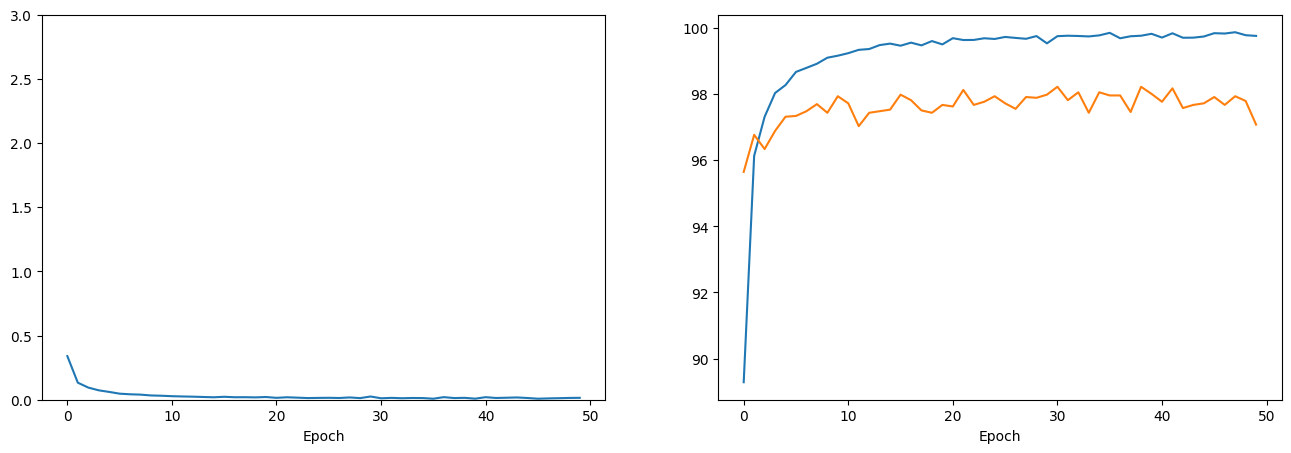

In [21]:
fig, aa = plt.subplots(1, 2, figsize = (16, 5))

aa[0].plot(trainLoss)
aa[0].set_xlabel('Epoch')
aa[0].set_ylim(0, 3)


aa[1].plot(trainAcc)
aa[1].set_xlabel('Epoch')
aa[1].plot(testAcc)

plt.show()